In [9]:
from pynq import Overlay

#fft_ov = Overlay("design_1_wrapper.xsa")
fft_ov = Overlay("design_1_wrapperV2.xsa")
fft_pipeN8 = fft_ov.fft_pipe_N8_0.mmio

In [10]:
# Sample generator
import numpy as np
N = 8
FXP = 1024
data_real = np.array([])
data_imag = np.array([])
data_complex = np.array([])

for i in range (N):
    data_real = np.append(data_real,np.random.rand())
    data_imag = np.append(data_imag,np.random.rand())

    
data_complex = data_real + 1j*data_imag

#Convert data to data fixed-point 14:10
for i in range (N):
    data_real[i] =  int(data_real[i]*FXP)
    data_imag[i] =  int(data_imag[i]*FXP)

    
    
print(data_real)
print(data_imag)
print(data_complex)

[940. 557. 151.  42. 102. 640. 597. 194.]
[643. 281. 384. 875. 995. 595. 570. 842.]
[0.91867303+0.62856508j 0.54403278+0.27526875j 0.14779289+0.3750893j
 0.04137681+0.854954j   0.09975619+0.97202133j 0.62540415+0.58120618j
 0.5838564 +0.55709187j 0.18984686+0.82248115j]


In [11]:
#Sample function
import math

def fft_sample(x):
    N = len(x)
    if N == 1:
        return [x[0]]
    X = [0] * N
    even = fft_sample(x[:N:2])
    odd = fft_sample(x[1:N:2])
    for k in range(N // 2):
        w = math.e ** (-2j * math.pi * k / N)
        X[k] = even[k] + w * odd[k]
        X[k + N // 2] = even[k] - w * odd[k]
    return X

In [28]:
# FFT Implementation on FPGA (Pipeline only for FFT N = 8)

N_size = 8
start_offset = 0
ready_offset = 132
in_buffer_offset = [x*4 for x in range(1,17)]
out_buffer_offset = [x*4 for x in range(17,33)]

def convert_for_signed_24bit(number):
    if number >= 0x800000:
        return number - 0x1000000
    else:
        return number

def fft_pipelineN8(in_r, in_i):
    out_r = np.array([])
    out_i = np.array([])
    fft_pipeN8.write(start_offset,0)
    for i in range(N_size):
        fft_pipeN8.write(in_buffer_offset[i],int(in_r[i]))
        fft_pipeN8.write(in_buffer_offset[i+N_size],int(in_i[i]))
    start2_ = time.time()
    fft_pipeN8.write(start_offset,1)    
    while (fft_pipeN8.read(ready_offset) == 0):
        pass 
    stop2_ = time.time()
    for i in range(N_size):
        out_r = np.append(out_r, fft_pipeN8.read(out_buffer_offset[i]))
        out_i = np.append(out_i, fft_pipeN8.read(out_buffer_offset[i+N_size]))
    for i in range(N_size):
        out_r[i] = convert_for_signed_24bit(out_r[i])
        out_i[i] = convert_for_signed_24bit(out_i[i])
    #fft_pipeN8.write(start_offset,0)
    return (out_r, out_i, stop2_-start2_)
    

In [29]:
import time

#Compute FFT using sample function
start1 = time.time()
X_sample = fft_sample(data_complex)
stop1 = time.time()

#Compute FFT using FFT Implementation on FPGA (Pipeline only for FFT N = 8)
start2 = time.time()
X_fpga_r , X_fpga_i, calc_time = fft_pipelineN8(data_real, data_imag)
stop2 = time.time()


X_fpga_complex = np.array([])
X_fpga_complex = X_fpga_r + 1j*X_fpga_i
X_fpga_complex = X_fpga_complex/1024

Sample function -  Time =  0.0005178452
Pipeline FFT N=8 - Time =  0.0015058517 (with data pushing and reading) 
Pipeline FFT N=8 - Time =  0.0000252724 (time only between START-READY state)
RMSE: 0.00229131662017


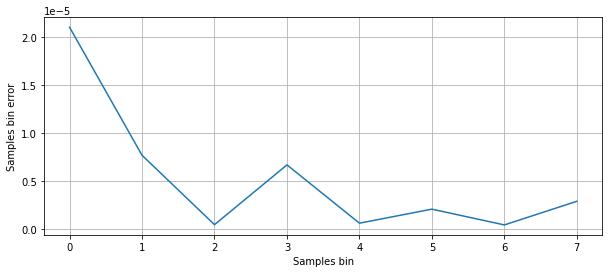

In [39]:
import matplotlib.pyplot as plt

# Error between sample implementation and fpga implementation
X_err = np.abs(X_fpga_complex - X_sample)**2
# RMSE
X_RMSE = np.sqrt(np.mean(X_err))
print('Sample function -  Time = ',"%.10f" % (stop1-start1))
print('Pipeline FFT N=8 - Time = ',"%.10f" % (stop2-start2),'(with data pushing and reading) ')
print('Pipeline FFT N=8 - Time = ',"%.10f" % calc_time, '(time only between START-READY state)')
print('RMSE:', np.round(X_RMSE, 15))
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.plot(X_err)
ax.set_ylabel('Samples bin error')
ax.set_xlabel('Samples bin')
plt.grid()
plt.show()